### Import modules

In [1]:
import getpass
import sys
import time

from collections import defaultdict
from tqdm import tqdm, tqdm_notebook

import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import string

In [2]:
%matplotlib inline

In [3]:
getpass.getuser()

'danieldomingo'

### Loading data files

In [4]:
DATA_DIR = '../data'

In [5]:
plant_disease_data = pd.read_csv(
    f'{DATA_DIR}/processed/plant_disease_associations.tsv.gz',
    sep='\t',
    compression='gzip',
)
plant_disease_data.head(3)

,plant_curie,plant_name,disease_curie,database,evidence
0,ncbitaxon:3369,Cryptomeria japonica,mondo:0005324,bern2,10067319_8
1,ncbitaxon:3369,Cryptomeria japonica,mondo:0005324,bern2,10094290_4
2,ncbitaxon:3369,Cryptomeria japonica,mondo:0005324,bern2,10336604_1


In [6]:
plant_chemical_data = pd.read_csv(
    f'{DATA_DIR}/processed/plant_chemical_associations.tsv.zip',
    sep='\t',
    compression='zip',
)
plant_chemical_data.head(3)

,plant_curie,plant name,chemical_curie,chemical name,database,evidence
0,ncbitaxon:1000425,Pimpinella major,pubchem.compound:3527,"3-[(3,4-Dihydroxyphenyl)(hydroxy)methylidene]-...",coconut,Relation from COCONUT
1,ncbitaxon:1000425,Pimpinella major,pubchem.compound:68082,Isobergapten,coconut,Relation from COCONUT
2,ncbitaxon:1000425,Pimpinella major,pubchem.compound:5315272,Talbotaflavone,coconut,Relation from COCONUT


### Create subsets for each entities

In [7]:
### PLANT - DISEASE DATA

plants_in_bern2 = set(plant_disease_data[
    plant_disease_data['database'] == 'bern2'
]['plant_curie'])

plants_in_db = set(plant_disease_data[
    plant_disease_data['database'] != 'bern2'
]['plant_curie'])

diseases_in_bern2 = set(plant_disease_data[
    plant_disease_data['database'] == 'bern2'
]['disease_curie'])

diseases_in_db = set(plant_disease_data[
    plant_disease_data['database'] != 'bern2'
]['disease_curie'])

len(plants_in_bern2), len(plants_in_db), len(diseases_in_bern2), len(diseases_in_db)

(4826, 2393, 1811, 867)

In [8]:
### PLANT - CHEMICAL DATA

plants_in_coconut = set(plant_chemical_data[
    plant_chemical_data['database'] == 'coconut'
]['plant_curie'])

plants_in_lotus = set(plant_chemical_data[
    plant_chemical_data['database'] == 'lotus'
]['plant_curie'])

chemicals_in_coconut = set(plant_chemical_data[
    plant_chemical_data['database'] == 'coconut'
]['chemical_curie'])

chemicals_in_lotus = set(plant_chemical_data[
    plant_chemical_data['database'] == 'lotus'
]['chemical_curie'])

len(plants_in_coconut), len(plants_in_lotus), len(chemicals_in_coconut), len(chemicals_in_lotus)

(11472, 13463, 34029, 46699)

In [9]:
### PLANT - CHEMICAL TOTAL STATS

plants = plants_in_coconut.union(plants_in_lotus)
chemicals = chemicals_in_coconut.union(chemicals_in_lotus)
len(plants), len(chemicals)

(18094, 71179)

In [10]:
### Medicinal plants space

med_plants = plants_in_bern2.union(plants_in_db)
chem_med_plants = plants.intersection(med_plants)
len(chem_med_plants)

4028

In [11]:
### MED PLANT - CHEMICAL DATA

med_plants_in_coconut = plants_in_coconut.intersection(med_plants)

med_plants_in_lotus = plants_in_lotus.intersection(plants_in_lotus)

med_chemicals_in_coconut = set(plant_chemical_data.loc[
    (plant_chemical_data['database'] == 'coconut') & 
    (plant_chemical_data['plant_curie'].isin(med_plants_in_coconut))
]['chemical_curie'])

med_chemicals_in_lotus = set(plant_chemical_data.loc[
    (plant_chemical_data['database'] == 'lotus') &
    (plant_chemical_data['plant_curie'].isin(med_plants_in_lotus))
]['chemical_curie'])

len(med_plants_in_coconut), len(med_plants_in_lotus), len(med_chemicals_in_coconut), len(med_chemicals_in_lotus)

(2706, 13463, 23934, 46699)

### Getting plant-chemical and plant-disease distribution

In [12]:
plant_disease_dict = defaultdict(set)

for plant_curie, plant_name, disease_curie, db_name, pmid in tqdm(
    plant_disease_data.values, desc='Plant-disease dictionary'
):
    plant_disease_dict[plant_curie].add(disease_curie)
    
plant_chemical_dict = defaultdict(set)

for plant_curie, plant_name, chemical_curie, chemical_name, db_name, pmid in tqdm(
    plant_chemical_data.values, desc='Plant-chemical dictionary'
):
    plant_chemical_dict[plant_curie].add(chemical_curie)

Plant-chemical dictionary: 100%|██████████████████████████████████████████████████| 330655/330655 [00:00<00:00, 498132.66it/s]


In [13]:
plant_disease_distribution = [
    len(disease_set)
    for plant_name, disease_set in plant_disease_dict.items()
]

med_plant_chemical_distribution = [
    len(chemical_set)
    for plant_name, chemical_set in plant_chemical_dict.items()
    if plant_name in chem_med_plants
]

### Venn Diagrams

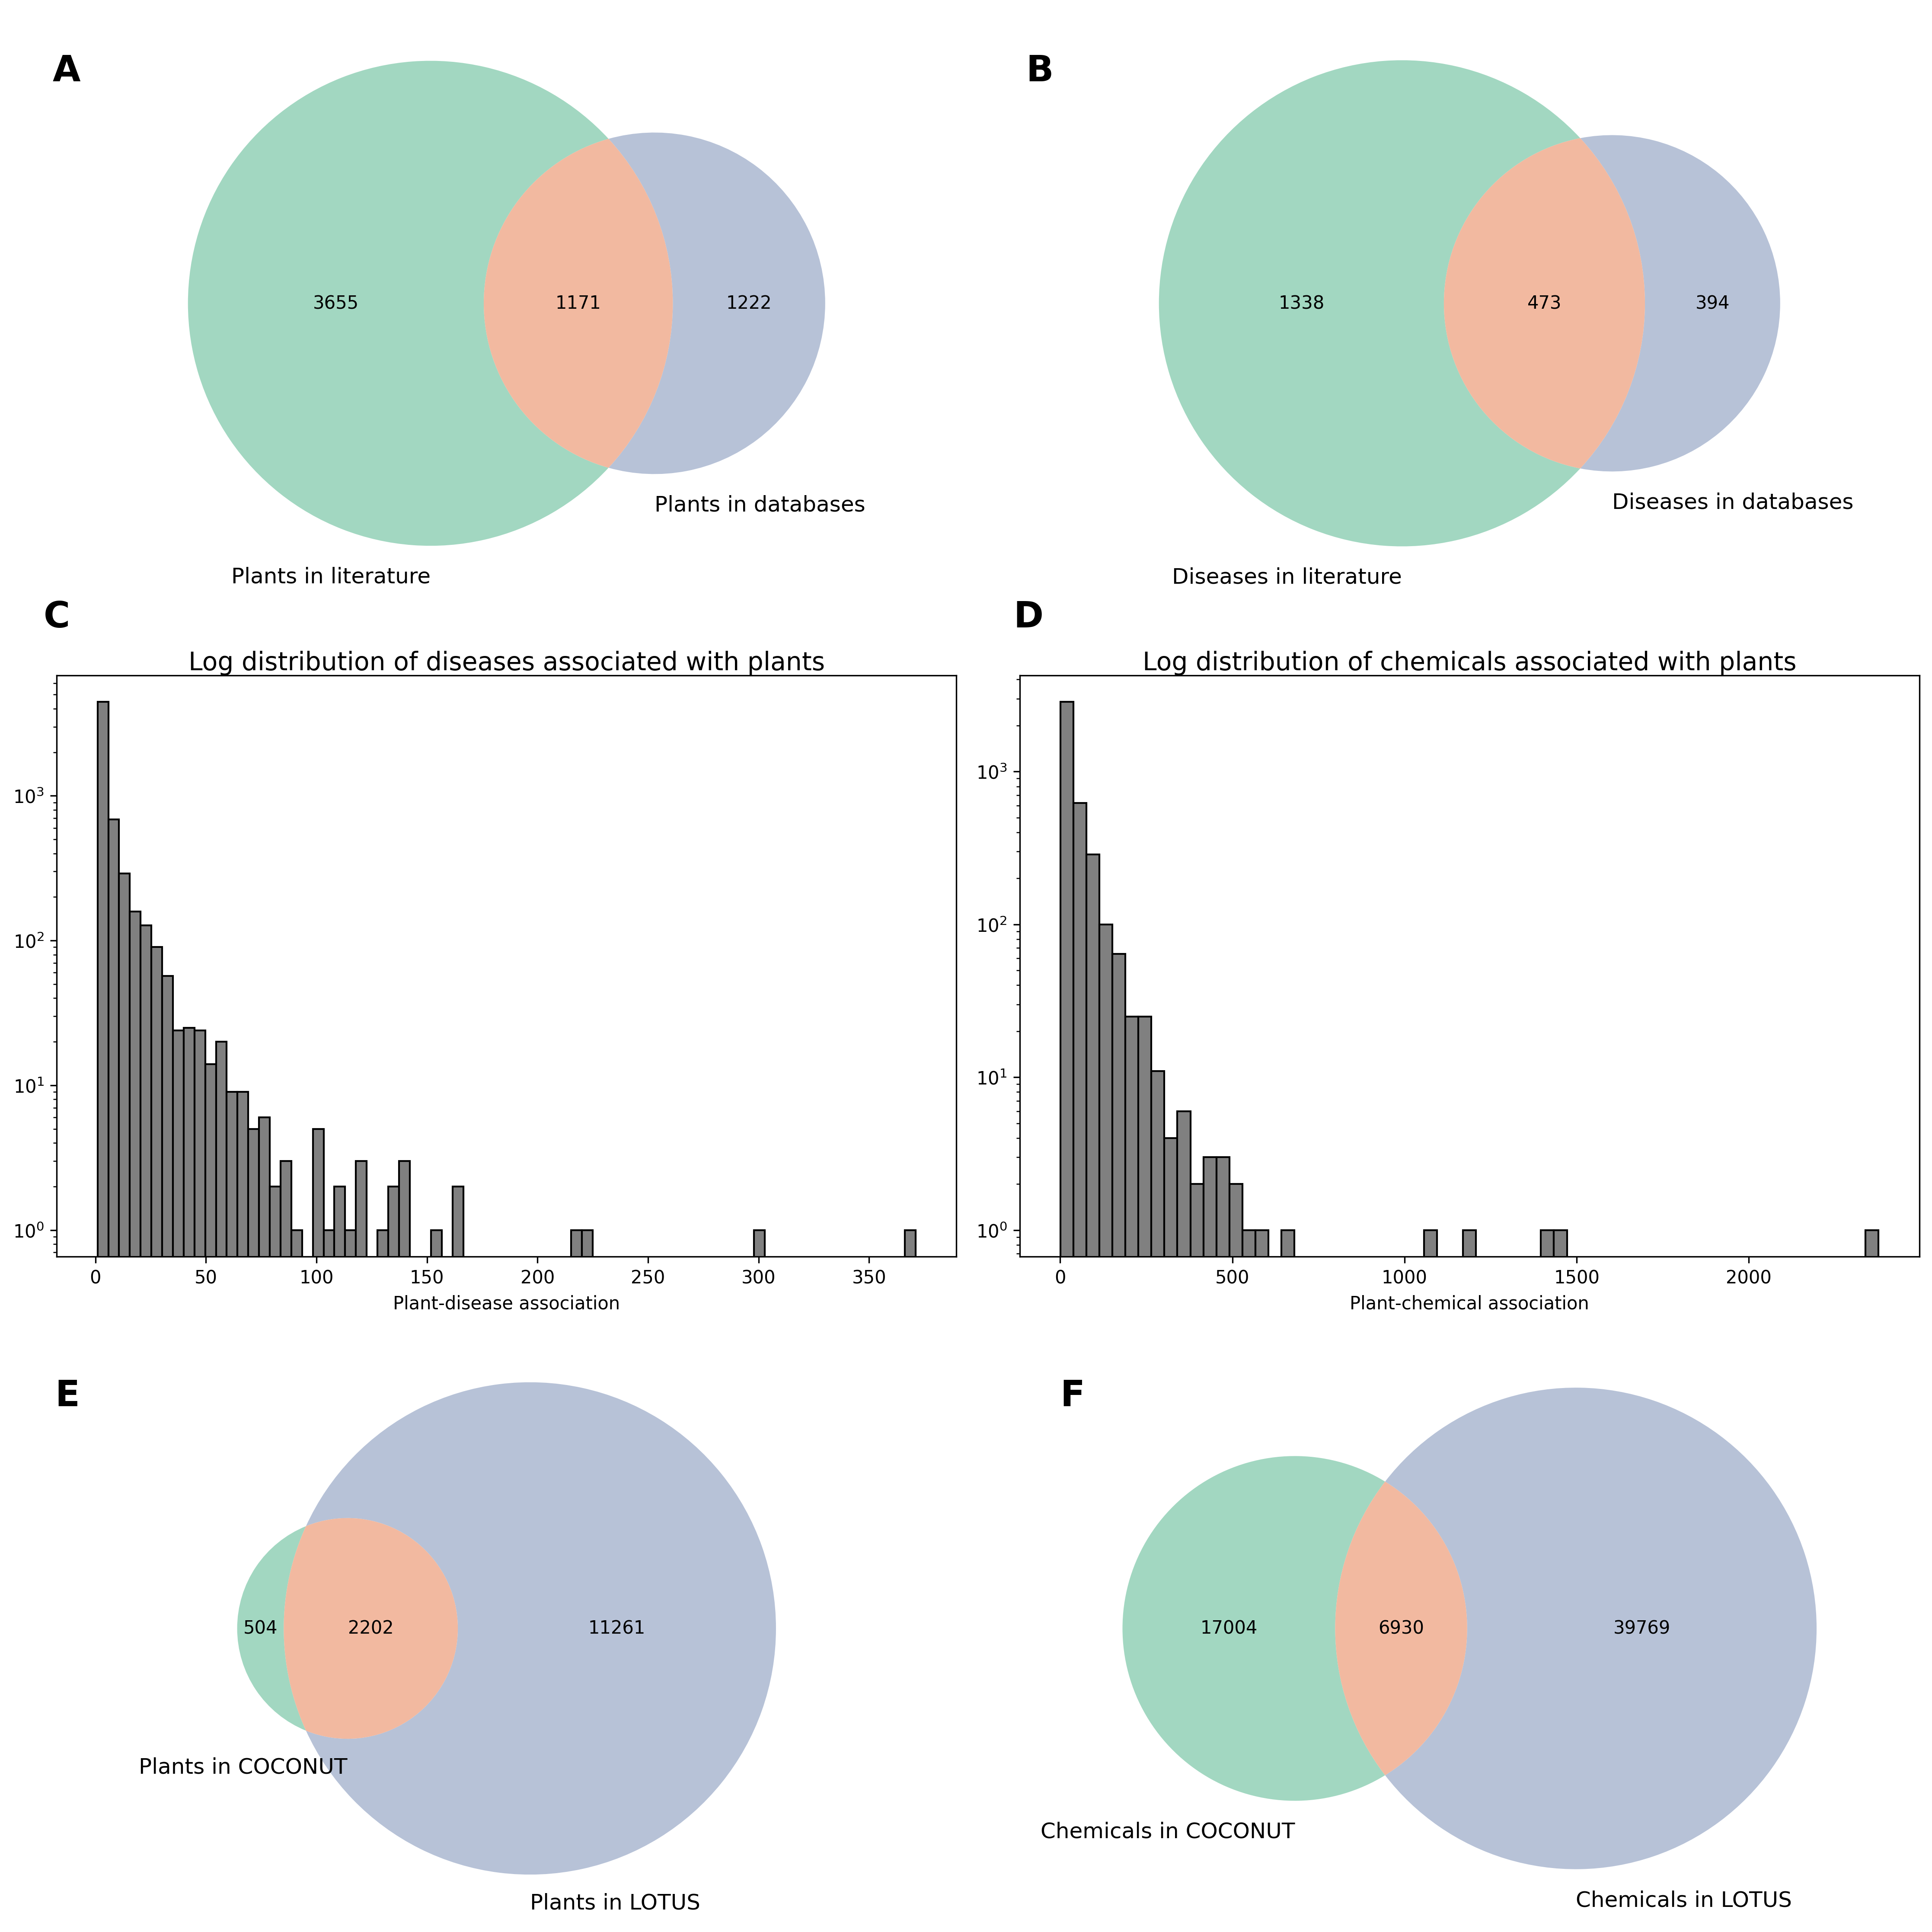

In [14]:
plt.figure(dpi=300, figsize=([15,15]))

plt.subplots_adjust(wspace=0)

plt.subplot(3,2,1)
c1 = venn2(
    [plants_in_bern2, plants_in_db],
    set_labels=('Plants in literature', 'Plants in databases'),
    set_colors=('#8BCEB2', '#a5b3ce'),
    alpha=.8
)
c1.get_patch_by_id('11').set_color('#efa888')
c1.get_patch_by_id('11').set_edgecolor('none')
plt.text(-0.1, 0.9, string.ascii_uppercase[0],  
        size=20, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)

plt.subplot(3,2,2)
c2 = venn2(
    [diseases_in_bern2, diseases_in_db],
    set_labels=('Diseases in literature', 'Diseases in databases'),
    set_colors=('#8BCEB2', '#a5b3ce'),
    alpha=.8
)
c2.get_patch_by_id('11').set_color('#efa888')
c2.get_patch_by_id('11').set_edgecolor('none')
plt.text(-0.1, 0.9, string.ascii_uppercase[1],  
        size=20, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)

plt.subplot(3,2,3)
plt.hist(plant_disease_distribution, bins=76, ec='black', color='grey')
plt.yscale("log")
plt.xlabel('Plant-disease association')
plt.title('Log distribution of diseases associated with plants',horizontalalignment='center', size=14,
        verticalalignment='center')
plt.text(0, 1.1, string.ascii_uppercase[2],  
        size=20, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)

plt.subplot(3,2,4)
plt.hist(med_plant_chemical_distribution, bins=63, ec='black', color='grey')
plt.yscale("log")
plt.xlabel('Plant-chemical association')
plt.title('Log distribution of chemicals associated with plants', horizontalalignment='center', size=14,
        verticalalignment='center')
plt.text(0.01, 1.1, string.ascii_uppercase[3],  
        size=20, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)

plt.subplot(3,2,5)
c3 = venn2(
    [med_plants_in_coconut, med_plants_in_lotus],
    ('Plants in COCONUT', 'Plants in LOTUS'),
    set_colors=('#8BCEB2', '#a5b3ce'),
    alpha=.8
)
c3.get_patch_by_id('11').set_color('#efa888')
c3.get_patch_by_id('11').set_edgecolor('none')
plt.text(-0.2, 0.9, string.ascii_uppercase[4],  
        size=20, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)

plt.subplot(3,2,6)
c4 = venn2(
    [med_chemicals_in_coconut, med_chemicals_in_lotus],
    ('Chemicals in COCONUT', 'Chemicals in LOTUS'),
    set_colors=('#8BCEB2', '#a5b3ce'),
    alpha=.8
)
c4.get_patch_by_id('11').set_color('#efa888')
c4.get_patch_by_id('11').set_edgecolor('none')
plt.text(0, 0.9, string.ascii_uppercase[5],  
        size=20, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)

plt.tight_layout()
plt.savefig(f'{DATA_DIR}/figures/figure_1.png', bbox_inches='tight')
plt.show()

In [15]:
from statistics import mean
mean(plant_disease_distribution), mean(med_plant_chemical_distribution)

(6.495039682539683, 37.794687189672295)